In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [110]:
def load(file_path):
    return pd.read_csv(file_path)

def transform(df):
    df.rename(columns={' Income ': 'Income'}, inplace=True)

    # Convert income into an interpretable float from its initial $ string 
    df['Income'] = df['Income'].str.strip().str.replace('$', '').str.replace(',', '').astype('float')
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%m/%d/%y')

    # Make Marital Status groups consistent
    df.loc[df['Marital_Status'].isin(['YOLO', 'Absurd', 'Alone']), 'Marital_Status'] = 'Single'

    # Handle missing values
    df['Income'].fillna(df['Income'].median(), inplace=True)

    ### Feature Engineering

    # Create Age from birth year
    df['Age'] = 2025 - df['Year_Birth']

    # Calculate total spending
    spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
    df['Total_Spending'] = df[spending_cols].sum(axis=1)

    # Calculate total children
    df['Total_Children'] = df['Kidhome'] + df['Teenhome']

    # Calculate total purchases
    purchases_cols = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
    df['Total_Purchases'] = df[purchases_cols].sum(axis=1)

    # Total campaign responses
    campaign_cols = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2']
    df['Total_Campaign_Accepted'] = df[campaign_cols].sum(axis=1)

    # Average order value
    df['Avg_Order_Value'] = df['Total_Spending'] / df['Total_Purchases'].replace(0, 1)

    ### Categorical Encoding

    # Education
    education_mapping = {'Basic': 1, '2n Cycle': 2, 'Graduation': 3, 'Master': 4, 'PhD': 5}
    df['Education_Numeric'] = df['Education'].map(education_mapping)

    # One-hot encode marital status
    df = pd.get_dummies(df, columns=['Marital_Status'], prefix='Marital')

    # One-hot encode country
    df = pd.get_dummies(df, columns=['Country'], prefix='Country')

    return df

def remove_outliers(df):
    df = df[df['Income'] != 666666]
    Q1 = df['Age'].quantile(0.25)
    Q3 = df['Age'].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df['Age'] >= Q1 - 1.5 * IQR) & (df['Age'] <= Q3 + 1.5 * IQR)]
    return df

In [111]:
data = load('marketing_data.csv')

data = transform(data)
data.head()

,ID,Year_Birth,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,Marital_Together,Marital_Widow,Country_AUS,Country_CA,Country_GER,Country_IND,Country_ME,Country_SA,Country_SP,Country_US
0,1826,1970,Graduation,84835.0,0,0,2014-06-16,0,189,104,...,False,False,False,False,False,False,False,False,True,False
1,1,1961,Graduation,57091.0,0,0,2014-06-15,0,464,5,...,False,False,False,True,False,False,False,False,False,False
2,10476,1958,Graduation,67267.0,0,1,2014-05-13,0,134,11,...,False,False,False,False,False,False,False,False,False,True
3,1386,1967,Graduation,32474.0,1,1,2014-05-11,0,10,0,...,True,False,True,False,False,False,False,False,False,False
4,5371,1989,Graduation,21474.0,1,0,2014-04-08,0,6,16,...,False,False,False,False,False,False,False,False,True,False


In [112]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Response', 'Complain', 'Age', 'Total_Spending', 'Total_Children',
       'Total_Purchases', 'Total_Campaign_Accepted', 'Avg_Order_Value',
       'Education_Numeric', 'Marital_Divorced', 'Marital_Married',
       'Marital_Single', 'Marital_Together', 'Marital_Widow', 'Country_AUS',
       'Country_CA', 'Country_GER', 'Country_IND', 'Country_ME', 'Country_SA',
       'Country_SP', 'Country_US'],
      dtype='object')

In [113]:
data.dtypes

ID                                  int64
Year_Birth                          int64
Education                          object
Income                            float64
Kidhome                             int64
Teenhome                            int64
Dt_Customer                datetime64[ns]
Recency                             int64
MntWines                            int64
MntFruits                           int64
MntMeatProducts                     int64
MntFishProducts                     int64
MntSweetProducts                    int64
MntGoldProds                        int64
NumDealsPurchases                   int64
NumWebPurchases                     int64
NumCatalogPurchases                 int64
NumStorePurchases                   int64
NumWebVisitsMonth                   int64
AcceptedCmp3                        int64
AcceptedCmp4                        int64
AcceptedCmp5                        int64
AcceptedCmp1                        int64
AcceptedCmp2                      

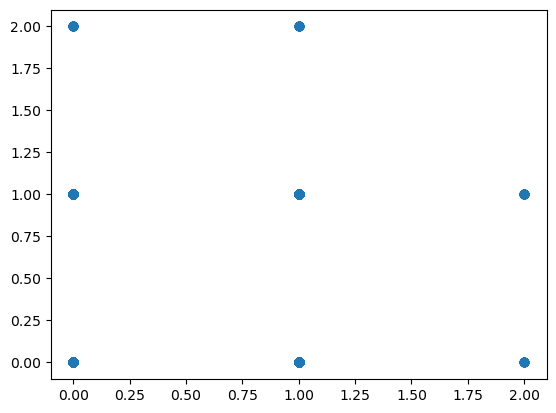

In [114]:
plt.scatter(x="Kidhome", y='Teenhome', data=data)

The plot above reveals that the `Kidhome` and `Teenhome` variables aren't designed to be dependent necessarily. Evidenced by the fact that there are entrants with teens at home and no kids and vice versa, meaning that we could aggregate the two columns to have a `Havekids` boolean feature, an `Total_Kids` numeric column, or make indicators as to whether an entrant has kids or teens rather than a numerical count of the respective groups.

In [115]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
ID,2240.0,5592.159821,0.0,2828.25,5458.5,8427.75,11191.0,3246.662198
Year_Birth,2240.0,1968.805804,1893.0,1959.0,1970.0,1977.0,1996.0,11.984069
Income,2240.0,52237.975446,1730.0,35538.75,51381.5,68289.75,666666.0,25037.955891
Kidhome,2240.0,0.444196,0.0,0.0,0.0,1.0,2.0,0.538398
Teenhome,2240.0,0.50625,0.0,0.0,0.0,1.0,2.0,0.544538
Dt_Customer,2240,2013-07-10 10:01:42.857142784,2012-07-30 00:00:00,2013-01-16 00:00:00,2013-07-08 12:00:00,2013-12-30 06:00:00,2014-06-29 00:00:00,NaN
Recency,2240.0,49.109375,0.0,24.0,49.0,74.0,99.0,28.962453
MntWines,2240.0,303.935714,0.0,23.75,173.5,504.25,1493.0,336.597393
MntFruits,2240.0,26.302232,0.0,1.0,8.0,33.0,199.0,39.773434
MntMeatProducts,2240.0,166.95,0.0,16.0,67.0,232.0,1725.0,225.715373


In [116]:
data.describe(include='object').T

,count,unique,top,freq
Education,2240,5,Graduation,1127


In [117]:
for col in data.select_dtypes('object').columns:
    print(col + ": " + str(set(data[col])))

Education: {'Basic', 'Graduation', 'PhD', 'Master', '2n Cycle'}


Based on the print statement above, there's some preprocessing that needs to be to make the `Marital_Status` values more consistent since 'YOLO', 'Absurd', and 'Alone' are not typical groups and could be considered 'Single'.

In [118]:
data.shape

(2240, 46)

In [119]:
# Check for outliers within the listed columns
for col in ['Income', 'Age', 'Total_Spending']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    print(f"Removing outliers from {col} has a shape of {data[(data[col] >= Q1 - 1.5 * IQR) & (data[col] <= Q3 + 1.5 * IQR)].shape}")
    outlier = data[(data[col] < Q1 - 1.5 * IQR) | (data[col] > Q3 + 1.5 * IQR)]
    print(f"Outlier indices are {outlier.index}")
    print(f"{outlier[col]}\n")

Removing outliers from Income has a shape of (2232, 46)
Outlier indices are Index([325, 497, 527, 731, 853, 1826, 1925, 2204], dtype='int64')
325     157146.0
497     160803.0
527     666666.0
731     162397.0
853     157733.0
1826    153924.0
1925    156924.0
2204    157243.0
Name: Income, dtype: float64

Removing outliers from Age has a shape of (2237, 46)
Outlier indices are Index([513, 827, 2233], dtype='int64')
513     132
827     126
2233    125
Name: Age, dtype: int64

Removing outliers from Total_Spending has a shape of (2237, 46)
Outlier indices are Index([671, 672, 1404], dtype='int64')
671     2525
672     2525
1404    2524
Name: Total_Spending, dtype: int64



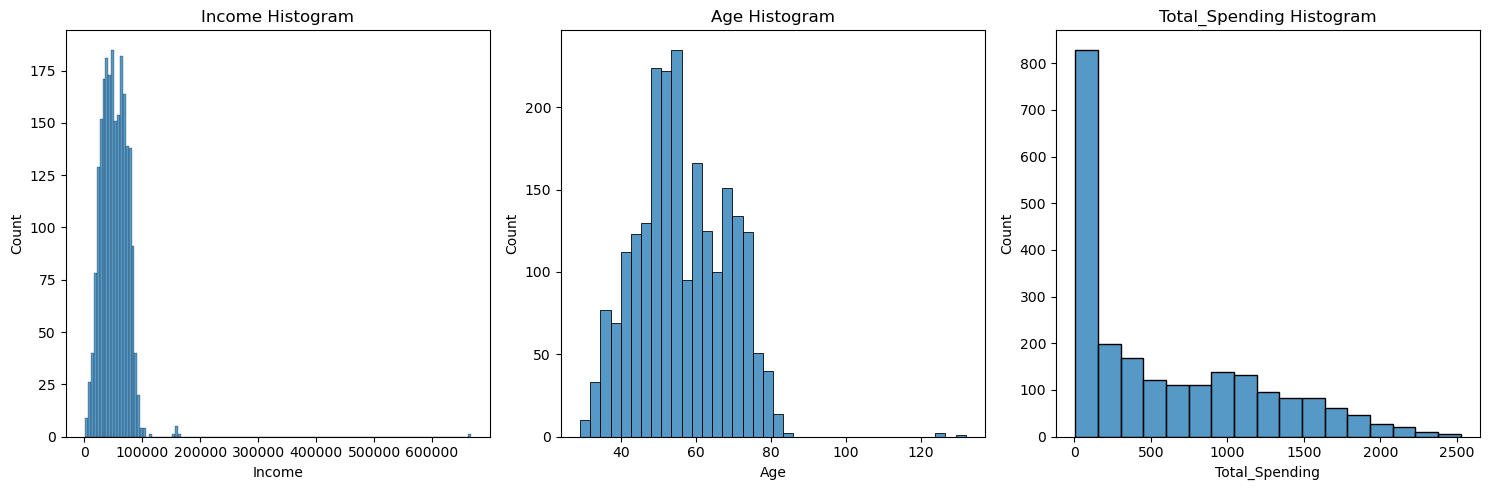

In [120]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i, col in enumerate(['Income', 'Age', 'Total_Spending']):
    sns.histplot(data[col], ax=axes[i])
    axes[i].set_title(f"{col} Histogram")
plt.tight_layout()
plt.show()

Based on the distribution of the `Age` and `Income` columns, the outliers that we are observing appear to be errors found in data entry. For example, the `Age` distribution appears to somewhat normal despite 3 instances where the age are above 120, which is abnormal for typical lifespans. Additionally, there's a singular entry where their income is $666,666; this kind of money is possible but unlikely to be indicative of a valid record. The other values that were listed as outliers are more realistic and represent achievable salaries, possibly representing an area of interest for segmentation or clustering (e.g. high income category). Similarly, the `Total_Spending` column does not require any actions on the outlier as the values may provide insights to customers who spend more and align with the right-skewed distribution. Therefore, we are going to remove the specified rows with extreme outliers in the `Age` and `Income` columns.

In [121]:
data = remove_outliers(data)
data.shape

(2236, 46)

In [122]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Response', 'Complain', 'Age', 'Total_Spending', 'Total_Children',
       'Total_Purchases', 'Total_Campaign_Accepted', 'Avg_Order_Value',
       'Education_Numeric', 'Marital_Divorced', 'Marital_Married',
       'Marital_Single', 'Marital_Together', 'Marital_Widow', 'Country_AUS',
       'Country_CA', 'Country_GER', 'Country_IND', 'Country_ME', 'Country_SA',
       'Country_SP', 'Country_US'],
      dtype='object')

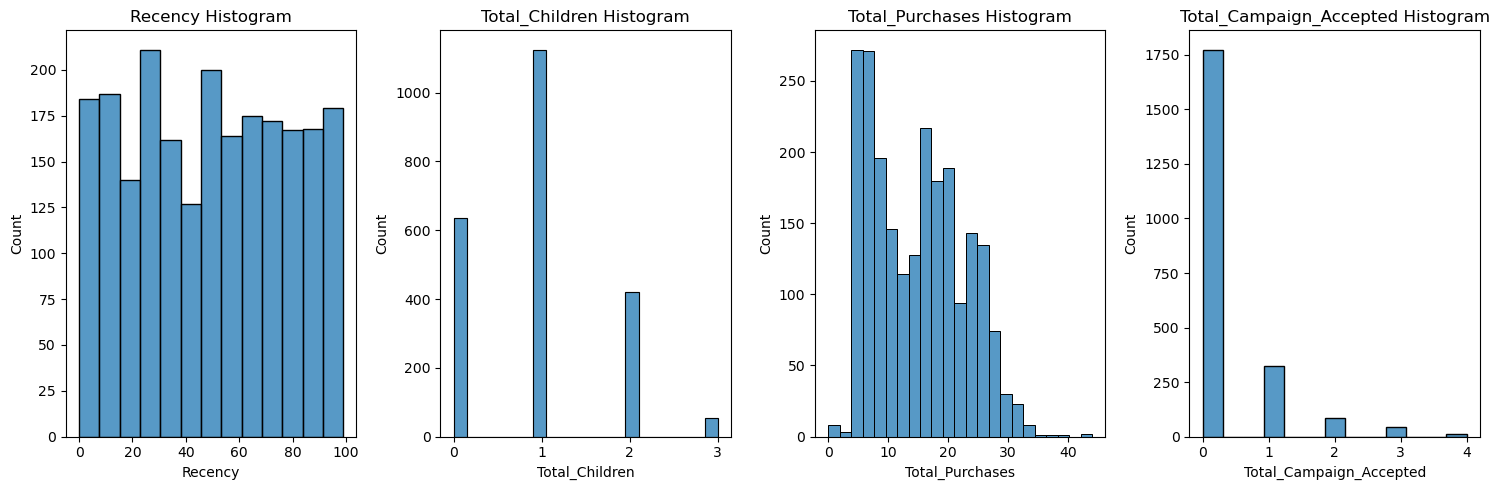

In [123]:
fig, axes = plt.subplots(1, 4, figsize=(15,5))

for i, col in enumerate(['Recency', 'Total_Children', 'Total_Purchases', 'Total_Campaign_Accepted']):
    sns.histplot(data[col], ax=axes[i])
    axes[i].set_title(f"{col} Histogram")
plt.tight_layout()
plt.show()

In [124]:
data[data.Total_Campaign_Accepted == 4]

,ID,Year_Birth,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,Marital_Together,Marital_Widow,Country_AUS,Country_CA,Country_GER,Country_IND,Country_ME,Country_SA,Country_SP,Country_US
38,3725,1961,PhD,84865.0,0,0,2013-05-09,1,1248,16,...,False,False,False,False,False,False,False,False,True,False
142,10089,1974,Graduation,102692.0,0,0,2013-04-05,5,168,148,...,False,False,False,False,False,False,False,True,False,False
152,8545,1954,Graduation,85683.0,0,0,2014-03-21,6,1296,17,...,False,False,False,False,False,False,False,False,True,False
259,5067,1994,Graduation,80134.0,0,0,2014-02-14,11,966,26,...,True,False,False,False,False,False,False,False,True,False
522,5758,1982,Graduation,65169.0,0,0,2014-01-14,23,1074,0,...,False,False,False,False,False,False,False,False,True,False
724,477,1986,Graduation,83512.0,0,0,2014-06-17,31,1060,61,...,False,False,False,False,False,False,False,False,True,False
1385,3174,1959,Graduation,87771.0,0,1,2013-05-22,61,1492,38,...,True,False,False,False,False,False,False,False,True,False
1386,5536,1959,Graduation,87771.0,0,1,2013-05-22,61,1492,38,...,True,False,False,True,False,False,False,False,False,False
1813,1509,1958,PhD,84460.0,0,0,2013-01-04,80,152,27,...,True,False,False,False,False,False,False,False,True,False
1913,3138,1956,Graduation,91249.0,0,0,2012-10-20,84,1324,27,...,False,False,False,False,False,False,False,False,True,False


## RFM Analysis

This section is going to provide us insights into customer value and behavior patterns.

In [125]:
def calculate_rfm_scores(df):
    # Recency: Days since last purchase
    # Frequency: Total number of purchases
    # Monetary: Total spending

    # Create quintile scores (1-5)
    df['R_Score'] = pd.qcut(df['Recency'], 5, labels=[5, 4, 3, 2, 1])
    df['F_Score'] = pd.qcut(df['Total_Purchases'].rank(method='first'), 5, labels=[1,2,3,4,5])
    df['M_Score'] = pd.qcut(df['Total_Spending'], 5, labels=[1,2,3,4,5])

    # Combined RFM Score
    df['RFM_Score'] = df['R_Score'].astype(str) + df['F_Score'].astype(str) + df['M_Score'].astype(str)
    
    return df

def identify_primary_product(df):
    spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

    for col in spending_cols:
        df[f"{col}_Pct"] = df[col] / df['Total_Spending']

    # Identify the primary product category for each customer
    df['Primary_Product'] = df[spending_cols].idxmax(axis=1)

    return df

def assign_customer_persona(row):
    """
    Assign customer persona based on RFM scores and behavior
    
    Business Rules:
    - Champions: Recent, frequent, high-value customers
    - At Risk: Previously valuable but haven't purchased recently
    - New Customers: Recent acquisition, low purchase history
    """
    r_score = int(row['R_Score'])
    f_score = int(row['F_Score']) 
    m_score = int(row['M_Score'])
    
    # Define clear thresholds
    if r_score >= 4 and f_score >= 4 and m_score >= 4:
        return 'Champions'
    elif r_score <= 2 and (f_score >= 3 or m_score >= 3):
        return 'At Risk'
    elif r_score >= 4 and f_score <= 2:
        return 'New Customers'
    elif f_score >= 4:
        return 'Loyal Customers'
    elif m_score >= 4:
        return 'Big Spenders'
    elif row['Total_Purchases'] > 0 and row['NumDealsPurchases'] / row['Total_Purchases'] > 0.4:
        return 'Price Sensitive'
    else:
        return 'Potential Loyalists'

In [126]:
data = calculate_rfm_scores(data)
data = identify_primary_product(data)
data['Customer_Persona'] = data.apply(assign_customer_persona, axis=1)

In [127]:
persona_counts = data['Customer_Persona'].value_counts()

persona_counts_with_percentages = round(data['Customer_Persona'].value_counts(normalize=True) * 100, 4)

persona_spending = data.groupby('Customer_Persona')['Total_Spending'].sum()

persona_spending_with_percentages = round(data.groupby('Customer_Persona')['Total_Spending'].sum() / data['Total_Spending'].sum() * 100, 4)

persona_segment_dist = pd.DataFrame({
    'Count': persona_counts,
    'Percentage': persona_counts_with_percentages,
    'Spending': persona_spending,
    'Spending_Perc': persona_spending_with_percentages
})
persona_segment_dist = persona_segment_dist.sort_values('Count', ascending=False)
persona_segment_dist

,Count,Percentage,Spending,Spending_Perc
Customer_Persona,,,,
Potential Loyalists,684,30.5903,92527,6.8286
At Risk,553,24.7317,531845,39.2510
New Customers,369,16.5027,27824,2.0535
Champions,278,12.4329,341654,25.2146
Loyal Customers,245,10.9571,232837,17.1837
Big Spenders,100,4.4723,127430,9.4045
Price Sensitive,7,0.3131,869,0.0641


Champions represent 12% of customers but generate 25% of revenue, however, we have 553 customers that are at risk but comprise of 39% of the overall spending. Potential Loyalists and New Customers provide an interesting avenue for campaigns because they are the 1st and 3rd most representative groups while attributing some of the least spending as a group. This suggests that we need both retention campaigns for At-Risk customers and acquisition campaigns to find more Champion-type customers or campaigns that will churn Potential Loyalists and New Customers into loyal customers.

In [128]:
persona_profiles = data.groupby('Customer_Persona').agg({
    'Age': 'mean',
    'Income': 'mean',
    'Total_Spending': 'mean',
    'Education_Numeric': 'mean'
}).round(2)
persona_profiles

,Age,Income,Total_Spending,Education_Numeric
Customer_Persona,,,,
At Risk,57.91,63137.44,961.75,3.57
Big Spenders,58.28,73491.24,1274.30,3.53
Champions,57.28,71094.88,1228.97,3.53
Loyal Customers,58.31,64259.22,950.36,3.53
New Customers,52.93,33838.49,75.40,3.36
Potential Loyalists,54.78,37634.38,135.27,3.36
Price Sensitive,54.14,23673.14,124.14,4.14


Champions are typically 57+ with $71K+ income, suggesting we should target affluent middle-aged customers for acquisition. Loyal customers share similar age characteristics to Champions, however, they often make $10K less and spend about $300 less than Champions. Loyal Customers appear to have similar characteristics to At Risk customers which suggests that we should assess our current marketing strategies and identify practices that will churn these customers. Lastly, New Customers and Potential Customers are identified by its lower age range of 52-54, while having a significantly lower income range of $33-$37K+ salary compared to the previously referenced groups. This suggests that campaigns that consider these lower income may pose effective at churning these customers to becoming more loyal. 

In [129]:
data.head(20).iloc[:, -13:]

,Country_US,R_Score,F_Score,M_Score,RFM_Score,MntWines_Pct,MntFruits_Pct,MntMeatProducts_Pct,MntFishProducts_Pct,MntSweetProducts_Pct,MntGoldProds_Pct,Primary_Product,Customer_Persona
0,False,5,3,5,535,0.158824,0.087395,0.318487,0.093277,0.158824,0.183193,MntMeatProducts,Big Spenders
1,False,5,4,3,543,0.804159,0.008666,0.110919,0.012132,0.000000,0.064125,MntWines,Loyal Customers
2,True,5,2,3,523,0.533865,0.043825,0.235060,0.059761,0.007968,0.119522,MntWines,New Customers
3,False,5,1,1,511,0.909091,0.000000,0.090909,0.000000,0.000000,0.000000,MntWines,New Customers
4,False,5,2,2,522,0.065934,0.175824,0.263736,0.120879,0.000000,0.373626,MntGoldProds,New Customers
5,False,5,3,5,535,0.281879,0.109060,0.344799,0.201342,0.026846,0.036074,MntMeatProducts,Big Spenders
6,False,5,5,5,555,0.632922,0.065844,0.207407,0.012346,0.027984,0.053498,MntWines,Champions
7,False,5,1,2,512,0.812500,0.000000,0.114583,0.000000,0.000000,0.072917,MntWines,New Customers
8,True,5,4,3,543,0.705882,0.000000,0.187500,0.038603,0.058824,0.009191,MntWines,Loyal Customers
9,False,5,4,3,543,0.705882,0.000000,0.187500,0.038603,0.058824,0.009191,MntWines,Loyal Customers


Given these `RFM_Score` values, we can define customer segments or personas pertaining to a specific score. For example, a customer that has a code of **555** signifies someone who has a high RFM score and is amongst the most frequent, high spending, and loyal customers that we have. In contrast, we may identify those with a score of **1XX** or **2XX** as customers with low frequency and at risk of losing them as consistent, loyal customers. With these scores, we're able to categorize customer groups and identify potential actions for these clusters.

In [130]:
data.to_csv('marketing_data_post_rfm.csv')